<a id="1.Summary"></a>
# 1.Summary

Logistic Regression, Neural Network, CNN, LSTM in Classiification and Sentiment Analysis

<a id="2.Table of Contents"></a>
# 2.Table of Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Table of Contents">Table of Contents</a></li>
    <li><a href="#3.Document Classification">Document Classification</a></li>
    <ul>
       <li><a href="#3.1 Preprocess">3.1 Preprocess</a></li>
       <ul>
           <li><a href="#3.1.1 Import Data">3.1.1 Import Data</a></li>
           <li><a href="#3.1.2 Clean Data">3.1.2 Clean Data</a></li>
           <li><a href="#3.1.3 EDA for hyperparameters">3.1.3 EDA for hyperparameters</a></li>
           <li><a href="#3.1.4 TFIDF">3.1.4 TFIDF</a></li>
           <li><a href="#3.1.5 GLOVE">3.1.5 GLOVE</a></li>
           <li><a href="#3.1.6 Split Data">3.1.6 Split Data</a></li>
       </ul>
       <li><a href="#3.2 Build Models">3.2 Build Models</a></li> 
       <ul>
           <li><a href="#3.2.1 CNN Model">3.2.1 CNN Model</a></li>
           <li><a href="#3.2.2 LSTM Model">3.2.2 LSTM Model</a></li>
           <li><a href="#3.2.3 Logistic Model">3.2.3 Logistic Model</a></li>
           <li><a href="#3.2.4 Normal Neural Network">3.2.4 Normal Neural Network</a></li>
       </ul>
       <li><a href="#3.3 Backpropagation">3.3 Backpropagation and Train</a></li>
       <li><a href="#3.4 Hyperparameter Tuning">3.4 Hyperparameter Tuning</a></li> 
       <li><a href="#3.5 Main Function">3.5 Main Function</a></li> 
       <li><a href="#3.6 Compare Models">3.6 Compare Models</a></li> 
    </ul>
    <li><a href="#4.Sentiment Analysis">Sentiment Analysis</a></li>
    <ul>
       <li><a href="#4.1 Read Data">4.1 Read Data</a></li>
       <li><a href="#4.3 Main Function">4.3 Main Function</a></li> 
    </ul>
    <li><a href="#5.Unused Code">Unused Code</a></li>
</ol>

<br>

In [1]:
import os
import re
import string
import sys
# monitor each step spend time
import time
# do not use equal for duplicate
import copy
import numpy as np
import pandas as pd

from IPython.display import Image

#we need use bs4 to eliminate html
from bs4 import BeautifulSoup
from collections import defaultdict
from nltk.corpus import stopwords
#it seems not working well
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
#for the neural network part, we need use tensorflow and keras as backend
from tensorflow import keras
#keras only can complete simple text preprocess work
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate, LSTM
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.utils import model_to_dot, plot_model
import matplotlib.pyplot as plt

#this function is used to monitor 
from tqdm.notebook import tqdm

import tensorflow_addons as tfa

from tensorflow_addons.metrics import F1Score

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

<a id="3.Document Classification"></a>
# 3.Document Classification
<a href="#1.Summary">Click this Link back to Top</a>

<a id="3.1 Preprocess Data"></a>
## 3.1 Preprocess Data
<a href="#1.Summary">Click this Link back to Top</a>

Divde each document into multiple paragramps. Each graph will be one example, one element in list. Text in the begining to demenstrate info will be discarded. All data will be formed into a DataFrame, which have "AUTHOR" and "CLASSIFY" column. This function only extract data without preprocess

This part is too scattered, we need integrate them into a CLASS or other type to transform and define hyperparamer more standarded

<a id="3.1.1 Import Data"></a>
### 3.1.1 Import Data
<a href="#1.Summary">Click this Link back to Top</a>

In [2]:
def import_data():
    """
    Each text have different issues, so i can not use one function to pro
    cess all raw data
    
    Return:
    --------
    df:DataFrame
        concatenate all data into one DataFrame with column ['AUTHOR', 'CLASSIFIY']
    data_1:list
        from Fyodor Dostoyevsky, and categrorial as 0
    data_2:list
        from Arthur Conan Doyle, and categorized as 1
    data_3:list
        from Jane Austen, and
    """
    print("*"*50,"Start import data", "*"*50)
    start_time = time.time()
    #Due to txt contain 'gbk', we have to read this file as binary code style, but binary leave more issues
    with open('03_data/11_Project Gutenberg Data/28054-0.txt', 'rb') as f:
        #First we use normal read
        #Second, we should decode binary with utf-8, which will turn binary back to string
        #Thrid, we need split raw text into paragraph, according to data, 
        #every paragraph are seperated by '\r\n\r\n'
        #In binary new line is"\r\n\r\n". In string new line is "\n\n"
        lines_1 = f.read().decode('utf-8').split('\r\n\r\n')
    #we only need main content, so eliminate header of each raw data. 
    #We only keep content from first paragraph title
    index_1 = lines_1.index('Chapter I. Fyodor Pavlovitch Karamazov')
    data_1 = lines_1[index_1+1:]
    while("" in data_1) : 
        data_1.remove("") 
    print(f'For category one, Fyodor Dostoyevsky, we have {len(data_1)} examples')
    
    
    #lines_2 can read directly
    with open('03_data/11_Project Gutenberg Data/pg1661.txt') as f:
        #we can use '\n\n' to split paragraph
        lines_2 = f.read().split('\n\n')
    #we only want main content of this book
    index_2 = lines_2.index('\nADVENTURE I. A SCANDAL IN BOHEMIA') 
    #due to technical reason, i can't elimiate some extra paragraph, so we add two after index
    data_2 = lines_2[index_2+2:]
    while("" in data_2) : 
        data_2.remove("") 
    print(f'For category two, Arthur Conan Doyle, we have {len(data_2)} examples')
    
    # open thrid author, still read binary
    with open('03_data/11_Project Gutenberg Data/pg31100.txt',  'rb') as f:
        # use wrapping line to split book into paragraphs
        lines_3 = f.read().decode('utf-8').split('\r\n\r\n')
    index_3 = lines_3.index('\r\nChapter 1')
    data_3 = lines_3[index_3+1:]
    while("" in data_3) : 
        data_3.remove("") 
    print(f'For category three, Fyodor Dostoyevsky, we have {len(data_3)} examples')
    
    #it's more convient to transform data into pandas DataFrame
    # dut to keras.to_category(), we change label from 1-3 to 0-2
    # build a dictionary for DataFrame transformation
    data = {'AUTHOR':data_1+data_2+data_3, 'CLASSIFY':[0]*len(data_1)+[1]*len(data_2)+[2]*len(data_3)}
    df = pd.DataFrame(data)
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End import_data() with {} second".format(cost_time), "*"*40, end='\n\n')
    
    return df

<br>

<a id="3.1.2 Clean Data"></a>
### 3.1.2 Clean Data
<a href="#1.Summary">Click this Link back to Top</a>

In [3]:
def clean_data(df, column_1, column_2, stopwords_fun = False):
    """
    steps
    1.lowercase()
    3.remove special puncuation
    4.remove string puncuation
    5.only reserve words
    6.remove stop words(if we eliminate most frequcen word, do we still this? and did this affect LSTM?) so i put a switch
    
    Argus:
    -----
    df:DataFrame
        Input come from import_data() [column_1] is garagrph corpus, ['CLASSIFY'] is author name for classifcation purpose
    stopwrods_fun:boolen
        True, remove stopwords; False, do not remove stopwords
        

    Return:
    ------
    courpus_df:DataFrame
        Because we use apply(lambda) to process each cell in DataFrame, so output is still that DataFrame
    """
    print("*"*50,"Start Clean data", "*"*50)
    start_time = time.time()
    #original datatype is serise, first transfrom to string and get lower() case text
    corpus_2 = df[column_1].str.lower()

    #using bs4 to eliminate html
    #soup = BeautifulSoup(corpus_2, 'lxml')
    #corpus_3 = soup.get_text()
    corpus_3 = corpus_2.apply(lambda x: remove_html(x))

    # this 
    #any speical punctuation in filter sring should add "\" before it
    #corpus_3 = re.sub('\[.*?\]', '', corpus_2.to_string)
    #corpus_2.str.replace('\\r','',regex=True)
    #!"#$%&()*\+,-./:;<=>\?@\[\\\]^_`{|}~\\t\\n\\r\“
    corpus_4 = corpus_3.apply(lambda x: remove_regex(x))
    
    #use sring.puncutation to eliminate, but we should first remove url. I believe this should be last step
    corpus_5 = corpus_4.apply(lambda x: remove_pun(x))
    

        
    #only reserve words
    pattern=r'[a-zA-Z][-._a-zA-Z]*[a-zA-Z]'
    corpus_6 = [" ".join(re.findall(pattern, x)) for x in corpus_5]
    
    
    if stopwords_fun:
        # remove stop words
        corpus_7 = []
        for sentence in tqdm(corpus_6):
            corpus_7.append(remove_stopwords(sentence))
#         corpus_7 = corpus_6.apply(lambda x: remove_stopwords(x))
#         corpus_7 = [remove_stopwords(x) for x in corpus_6]
    else:
        corpus_7 = corpus_6.copy()
        
    #we sitll need to manipulate with index because it contain important relationship between corpus and claasify
    #list to pd.Series
    corpus_8 = pd.Series(np.array(corpus_7))
    #extract classify column
    classify_col = df[column_2]
    #build a new data dictionary for generating DataFrame
    data_2 = {column_1:corpus_8, column_2:classify_col}
    #build a dataFrame with AUTHOR and CLASSIFY infomation. For now, the index of df and corpus_8 are identical
    corpus_df = pd.DataFrame(data_2)
#     print(type(corpus_df))
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End clean_data() with {} second".format(cost_time), "*"*40, end='\n\n')
    
    return corpus_df

def remove_pun(text):
    """
    The reason i use seperate function is that pandas.apply can manipulate with column value. 
    If we use loop directly, we will get a join corpus without paragraph structure
    
    Argus:
    ------
    text:string
        This input is one cell of DataFrame and we consider it as string to manipulate
    """
    no_pun = "".join([c for c in text if c not in string.punctuation])
    return no_pun

def remove_html(text):
    """
    Use bs4 to extract text
    """
    soup = BeautifulSoup(text, 'lxml')
    no_html = soup.get_text()
    return no_html

def remove_regex(text):
    """
    It was designed to remove special punctuation and character which we can't manipulate with string.puncutation effectively
    """
    #remove url
    no_reg = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    #remove numbers
    no_reg = re.sub('\w*\d\w*', '', no_reg)
    return no_reg

def remove_stopwords(sentence):
    stop_words_set = set(stopwords.words("english"))
    no_stopwords = " ".join([word for word in sentence.split(" ") if not word in stop_words_set])
#     for word in text:
#         if word not in stopwords.words("english"):
#             output = output + " " + word
    return no_stopwords

<br>

<a id="3.1.3 EDA for hyperparameters"></a>
### 3.1.3 EDA for hyperparameters
<a href="#1.Summary">Click this Link back to Top</a>

In [4]:
def eda(df):
    """
    use statisc and plot to determine hyperparameters, such as MAX_SEQ_LEN, TOP_WORDS
    Arugs:
    ------
    
    """
    # get the 'AUTHOR' column sentence length
    sentence_len = [len(x) for x in df[df.columns[0]]]
    sentence_len_arr = np.array(sentence_len)
    # change the type to numpy array and get 95%/90%/85%th percentile of the data value
    print(f"95%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 95)}")
    print(f"90%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 90)}")
    print(f"85%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 85)}")
    # get sorted 
    sentence_len.sort()
    plt.plot(np.arange(len(sentence_len)), sentence_len)
    plt.title("Sentence Length Distribution")
    plt.xlabel("Sentence Amount")
    plt.ylabel("Sentence Length")
    plt.show()
    print(f"For MAX_SEQ_LEN, 1000 words in one sentce will reasonable to preseve 90% sentence and delete outlier value")
    
    
    return None

<br>

<a id="3.1.4 TFIDF"></a>
### 3.1.4 TFIDF
<a href="#1.Summary">Click this Link back to Top</a>

TFIDF not word2vect, it just cacualte a numerical value for each word and concatenate into sentence to build a matrix

In [5]:
def tfidf(df, vectorizer=None, to_cat= True):
    """
    we use this function to complete preprocessing cleaning and tfidf function. Becuase we have to mentain 
    the relationship between corpus and his lable, we have several times list to DataFrame processes.
    I didn't show EDA part for setting up 
    
    Parameters:
    ------------
    df:pandas.DataFrame
        DataFrame, contain ['AUTHOR'] and ['CLASSIFY']. This is raw data.
        
    vectorizer:cofig
        When we apply to 
            
    Return:
    -------
    X_vector:array
        Dimension = (cleaned example, TOP_WORDS).Cleaned data and transformed to TFIDF format 
        with original sequence, which means can be matched withcooresponding y_labels.
        
    y_vector:
        Dimension = (no. cleaned examples, NUM_LABELS)=(9630,3)
        
    
    """
    print("*"*50,"Start TFIDF transfrom", "*"*50)
    start_time = time.time()
    # build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
    TOP_WORDS = 10000
    
    #tokens = corpus.apply(lambda x: x.split())
    #tokens = word_tokenize(tokens)
    #tokens = word_tokenize(corpus.str)
    
    #Stemming and Lemmatizing:   
    #Coreference resolution
    
   
     #*****************************cut down Part of optimization******************************************
#     #we can't directly drop column because index will dynamicly decrease, but we can gather index of drop
#     index_drop=[]
#     #iteration through all DataFrame
#     for i in range(len(df)):
#         #according to plot and statitc result,>600 have 2628, <60 have 3540, so we only need 60<data<600
#         if len(df.iloc[i,0])<60 or len(df.iloc[i,0])>600:
#             #delete too big and too small
#             index_drop.append(i)
#     print(f"before drop shape={df.shape}")
    
#     #drop row by list but remain old index number
#     df = df.drop(index_drop,axis=0)
#     print(f"after drop shape={df.shape}")
#     #re.finall(\w+)  
#     #*****************************cut down Part of optimization******************************************
    
    # inintial we need use vectorizer from train to process test data
    if vectorizer == None:
        vectorizer = TfidfVectorizer(stop_words='english', max_features = TOP_WORDS)
        #when we built a vect, we need to import all words as corpus combination to generate a TFIDF dictornary
        vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
        #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
        data_2 = vect.transform(df['AUTHOR']).toarray()
        X_vector = np.array(data_2)
    else:
        vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
        #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
        X_vector = vect.transform(df['AUTHOR']).toarray()

    if to_categorical == True:
        #To remain the relation between AUTHOR vector and CLASSIFY labels, we also output y_vector coorespondingly
        y_vector = to_categorical(np.array(df['CLASSIFY']))
    else:
        y_vector = df['CLASSIFY']
        
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End tfidf() with {} second".format(cost_time), "*"*40, end='\n\n')
    
    return df, X_vector, y_vector, vect

In [6]:
# df_3, X_vector, y_vector, vect = tfidf(df_2, vectorizer=None, to_cat= True)
# X_train, X_test, y_train, y_test = train_test_split(X_vector, y_vector, \
#                                                         test_size=0.2, random_state=0)

<br>

<a id="3.1.5 GLOVE"></a>
### 3.1.5 GLOVE
<a href="#1.Summary">Click this Link back to Top</a>

Use Tokenizer() to build padded matrix and use word vector from GLOVE to replace each word

In [7]:
def tokenize_data(df, column_1):
    """
    Arugs:
    -----
    df:DataFrame
        input DataFrame come from cleaned data
    
    """
    print("*"*50,"Start tokenize_data process", "*"*50)
    start_time = time.time()
    #we only want most 10,000 frequncy word.Although we can vector 29567 vector from our courps. 
    #Because we care most frequncy words in this sentence. for example "to" "of" "in". Maybe they are stopwords which should be eliminate
    #When can see word_index is the integrated dictionary for {word:number} pair but, after texts_to_sequcens() we only get most frequcn 10000
    TOP_WORDS = 10000
    
    #max_lenght define the max lenght of each sentence. Because the length of sentence is unbalance, we should ignore that too long part
    #after define this parameter, we also define the column of input matrix, which will be (No.examples , MAX_SEQ_LEN)
    MAX_SEQ_LEN = 500
    
    # only keep most frequcey {TOP_WORDS} words in croups
    # this parameters will not affect word_index, word_index still the totoal unique words list. 
    # Typically, we need use EDA to decide TOP_WORDS, capure the 80% most frequency words
    #tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
    tokenizer = Tokenizer(num_words=TOP_WORDS, oov_token="<OOV>")
    
    #transfor sentence to number vector
    tokenizer.fit_on_texts(sentence for sentence in df[column_1])
    
    #a = tokenizer.tranform(sten)
    
    #get the index of each indivudule word
    word_index = tokenizer.word_index
    
    #only choose most frequency 10,000 word_index and transfrom sentences with them into number vector like[564, 452, 23, 1]
    #the out of vocabulary wiht be give 1. Maximize number of texts_to_sequences() will be 9999, which means the 10000th frequceny will 
    #not show in this sequcen
    # this is temporay matrix container, we can replace with any other pretrained word vector
    sequences = tokenizer.texts_to_sequences(sentence for sentence in df[column_1])
    
    #maintain the sentence into same length
    #padded = pad_sequences(sequences)
    #If you want zero at the end, using padding='post'
    padded = pad_sequences(sequences, padding='post', maxlen=MAX_SEQ_LEN, truncating='post')
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End tokenizer_data with {} seconds".format(cost_time), "*"*40, end='\n\n')
    
    return tokenizer, word_index, sequences, padded

In [8]:
def glove_vect(word_index, df):
    """
    Argus:
    ------
    word_index:dict
        unique word dictionary from tokenize_data(). For this exampl,e word_index contain a dictionary from 27014 words to a number
        which number represent frequence and ordered from most ferquency to least frequency
    
    Returns:
    --------
    """
    print("*"*50,"Start glove_vect() process", "*"*50)
    start_time = time.time()
    # key = words;  values = word vector
    embedding_index = {}
    # split by line and first word in line is the word represented, following 50 numbers is pre-trained word vector
    f = open(r"D:\Downloads\glove.6B\glove.6B.50d.txt", 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        # embeddings_index will be a dict representing relationship between word and its pretrained 50 dimension vector
        embedding_index[word] = coefs
    f.close()
    
    # this is depended on which GLOVE was choosed
    EMBEDDING_DIM = 50
    # create a empty matrix to filled in glove, this matrix will be a 27015(27014+1) by 50 dimension matrix
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    # take the key=word and vlaue=i to iterate
    for word, i in tqdm(word_index.items()):
        # get the corresponding 50d vectro of "word" , for example 'the' (50,) vector
        embedding_vector = embedding_index.get(word)
        # if we can find word in GLOVE, he will have a None-Zero vector.
        # if we didn't find, this row/word will be np.zero
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End glove_vect() with {} seconds".format(cost_time), "*"*40, end='\n\n')
    return embedding_matrix, embedding_index

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

In [9]:
def embedding(word_index, padded, embedding_matrix):
    """
    Typically method is transform word vector first and find cooresponding word in a sentcen, using word vector to concatenate setence vector
    But i can't find a tokenize() function to using seperate dictionary to complete tokenziation process
    Embedding can do that. When you set trainale=False, the weights, embedding_matrix, will be change and mapping word vector by word
    
    Argus:
    -----
    word_index:dictionary
        provide a index <-> word mapping table
    
    padded:array
        (number of example, MAX_SEQ_LEN)
        
    embedding_matrix:dictionary
        provide a word <-> word vector mapping table
        
        
    """
    print("*"*50,"Start embedding process", "*"*50)
    start_time = time.time()
    # max sequence/sentence length is 100
    MAX_SEQ_LEN = 500
    EMBEDDING_DIM = 50
    sequence_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQ_LEN,
                                trainable=False)
    # (number of sample, MAX_SEQ_LEN, EMBEDING_DIM)
    output = embedding_layer(padded)
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End embedding() with {} seconds".format(cost_time), "*"*40, end='\n\n')
    
    return output, embedding_layer

<br>

<a id="3.1.6 Split Data"></a>
### 3.1.6 Split Data
<a href="#1.Summary">Click this Link back to Top</a>

In [10]:
def mapped(df):
    """
    one-hot vector classifier
    """
    y = df[column_2]
    #we set label dimension as (m, num_labels)
    NUM_LABELS = 3
    m=y.shape[0]
    y_mapped=np.zeros((m, NUM_LABELS))
    #Due to y is DataFrame, we need to manipulate it with .iloc[]
    #y.iloc[i] = 1/2/3 which is not convinent index of columns(0-2), so we need minus 1, which menas 1/2/3 will appear ONE at 0/1/2 postion
    for i in range(0,m):
        y_mapped[i, y.iloc[i]-1]=1;
    df['one-hot_CLASSIFY'] = list(y_mapped)
    
    return df

def split_data(padded,df, test_size=0.2):
    """
    Parameters:
    -----------
    df:DataFrame
        This is coming from data_import. This is still raw data with corpus inside. After data split
        tfidf() function will complete data preprocess
        
    test_size:float
        you can change percentage
    """
    print("*"*50,"Start train_test_split", "*"*50)
    start_time = time.time()
#     df =mapped(df)
    column_2 = df.columns[1]
    labels_2 = to_categorical(np.asarray(df[column_2]))
    # padded result only fit for CNN model
    X_vector = padded
#     y_vector = df['one-hot_CLASSIFY']
    y_vector = labels_2
    X_train, X_test, y_train, y_test = train_test_split(X_vector, y_vector, \
                                                        test_size=0.2, random_state=37)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 37)
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End embedding() with {} seconds".format(cost_time), "*"*40, end='\n\n')
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [11]:
# df_1 = import_data()
# df_2 = clean_data(df_1, column_1='AUTHOR', column_2='CLASSIFY')
# tokenizer, word_index, sequences, padded = tokenize_data(df_2, column_1=df_2.columns[0])
# X_train, X_test, X_val, y_train, y_test, y_val = split_data(padded,df_2, test_size=0.2)

In [12]:
# X_test.shape

<br>

<a id="3.2 Build Models"></a>
## 3.2 Build Models
<a href="#1.Summary">Click this Link back to Top</a>

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

<a id="3.2.1 CNN Model"></a>
### 3.2.1 CNN Model
<a href="#1.Summary">Click this Link back to Top</a>

In [13]:
def cnn_model(word_index, embedding_matrix, output_act='sigmoid', output_units=2):
    """
    For the CNN model, set zero paddings to the input matrix and use at least two convolutional layers 
    (each layer includes convolution, activation, and maxpooling).
    """
    # reset model variable
    model = None
    #*************Hyperparameter**************
    MAX_LENGTH = 500
    EMBEDDING_DIM = 50
    VOCAB_SIZE = 10000
    #*************Hyperparameter**************
    # input will be (100, 50) matrix, which is one sentence
    input_layer_1 = Input(shape=(MAX_LENGTH,), dtype='float32', name='input_layer_1')
    # embedding layer output shape is (number of examples, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)
    # input_dim = 27015, 
    embedding_layer_2 = Embedding( \
                                  input_dim = len(word_index) + 1, \
                                  output_dim = EMBEDDING_DIM, \
                                  weights=[embedding_matrix], \
                                  input_length=MAX_LENGTH, \
                                  trainable=False, \
                                  name = "embedding_layer_2"
                                 )(input_layer_1)
    # filer =32, kernel_size =5. output will be (number of example=190345, MAX_LENGTH-kneral_size+1 =100-5+1, filer )
    conv1d_layer_3 = Conv1D(filters = 32, kernel_size = 5, activation = 'relu', name = 'conv1D_layer_3')(embedding_layer_2)
    pooling_layer_4 = MaxPooling1D(pool_size = 5)(conv1d_layer_3)
    conv1d_layer_5 = Conv1D(filters = 32, kernel_size = 5 , activation ='relu', name = 'conv1D_layer_5')(pooling_layer_4)
    pooling_layer_6 = MaxPooling1D(pool_size = 5)(conv1d_layer_5)
    flatten_layer_7 = Flatten()(pooling_layer_6)
    dense_layer_8 = Dense(units = 128, activation='relu')(flatten_layer_7)
    output_layer_9 = Dense(output_units, activation = output_act)(dense_layer_8)
    model = Model(inputs = input_layer_1, outputs = output_layer_9, name='CNN_Model')
    model.summary()
    
    #first way to generate image
    dot_img_file = '04_images/16_CNN_model.png'
    plot_model(model, to_file=dot_img_file, show_shapes=True)
    display(Image(filename='04_images/16_CNN_model.png'))
#     plot_model(model, show_shapes=True, dpi=128))
    
    return model

<br>

<a id="3.2.2 LSTM Model"></a>
### 3.2.2 LSTM Model
<a href="#1.Summary">Click this Link back to Top</a>

In [14]:
def lstm_model(word_index, embedding_matrix, output_act='sigmoid', output_units=2):
    """
    """
    # reset model variable
    model = None
    #*************Hyperparameter**************
    MAX_LENGTH = 500
    EMBEDDING_DIM = 50
    VOCAB_SIZE = 10000
    #*************Hyperparameter**************
    # input will be (100, 50) matrix, which is one sentence
    input_layer_1 = Input(shape=(MAX_LENGTH,), dtype='float32', name='input_layer_1')
    # embedding layer output shape is (number of examples, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)
    # input_dim = 27015, 
    embedding_layer_2 = Embedding( \
                                  input_dim = len(word_index) + 1, \
                                  output_dim = EMBEDDING_DIM, \
                                  weights=[embedding_matrix], \
                                  input_length=MAX_LENGTH, \
                                  trainable=False, \
                                  name = "embedding_layer_2"
                                 )(input_layer_1)
    lstm_layer_3 = LSTM(50, dropout=0.2, recurrent_dropout=0.2)(embedding_layer_2)
    output_layer_4 = Dense(output_units, activation=output_act)(lstm_layer_3)
    model = Model(inputs = input_layer_1, outputs = output_layer_4, name='LSTM_Model')
    model.summary()
    
#         # Display model graph - optional
#     G = model_to_dot (model)
#     Image(G.create (prog = "dot", format = "png"))
#     display(Image(filename='04_images/16_CNN_model.png'))
    dot_img_file = '04_images/17_LSTM_model.png'
    plot_model(model, to_file=dot_img_file, show_shapes=True)
    display(Image(filename='04_images/17_LSTM_model.png'))

    return model

In [15]:
# lstm_model(word_index, embedding_matrix)

<br>

<a id="3.2.3 Logistic Model"></a>
### 3.2.3 Logistic Model
<a href="#1.Summary">Click this Link back to Top</a>

In [16]:
def lg_model(X_train, X_test, X_val, y_train, y_test, y_val):
    """
    """
    clf = LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    # get the label prediction
    y_pred = clf.predict(X_test)
    # get metrics
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    history = {'precision':precision, 'recall':recall, 'fbeta_score': fbeta_score}
    
    return history

In [17]:
# history = lg_model(X_train, X_test, X_val, y_train, y_test, y_val)

<br>

<a id="3.2.4 Normal Neural Network"></a>
### 3.2.4 Normal Neural Network
<a href="#1.Summary">Click this Link back to Top</a>

In [18]:
def nn_model(X_train, X_test, y_train, y_test, epoch_num =3):
    """
    Neural Network Mode
    
    Parameters:
    ----------
    X_train:array-like
        n / NUM_FEATURES = 10000 = MAX_DOC_LEN. This paramters is decided by tfidf function
    """
    #this hyperparamter linkage with tfidf() function
    MAX_DOC_LEN = 500
    #because this is three classify problem
    NUM_LABLES =3
    
    #*****************model built******************************
    input_layer = Input(shape=(MAX_DOC_LEN,), dtype='float32', name='input_layer')
    #
    dense_layer_1 = Dense(1024, activation='relu', name='dense_1')(input_layer)
    dense_layer_2 = Dense(64, activation='relu',name="dense_2")(dense_layer_1)
    #Due to multi-classify problem, we choose softmax as our output activation function
    output_layer = Dense(NUM_LABLES, activation='softmax',name="output")(dense_layer_2)
    model_a = Model(inputs=input_layer, outputs=output_layer, name='model_a')
    model_a.summary()
    #***************model built****************************
    
    
    dot_img_file = '04_images/10_model.png'
    tf.keras.utils.plot_model(model_a, to_file=dot_img_file, show_shapes=True)
    model_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model_a.fit(X_train, \
                          y_train, \
                            epochs = epoch_num, \
                            validation_data = (X_test, y_test), \
                            verbose = 1
                           )
    return history

In [19]:
# X_train, X_test, X_val, y_train, y_test, y_val = split_data(padded,df_2,test_size=0.2)
# history_nn = nn_model(X_train, X_test, y_train, y_test, epoch_num =3)

<br>

<a id="3.3 Backpropagation"></a>
## 3.3 Backpropagation and Train
<a href="#1.Summary">Click this Link back to Top</a>

use val to grid search and use test to caculate validataion

In [20]:
def compile_fit(model_input, X_train, X_test, X_val, y_train, y_test, y_val, loss_fun, epoch_num=3):
    """
    """
    start_time = time.time()
    print("*"*40,"Start {} Processing".format(model_input._name), "*"*40)
    
    model = model_input
    METRICS = [
          metrics.TruePositives(name='tp'),
          metrics.FalsePositives(name='fp'),
          metrics.TrueNegatives(name='tn'),
          metrics.FalseNegatives(name='fn'), 
          metrics.CategoricalAccuracy(name='accuracy'),
          metrics.Precision(name='precision'),
          metrics.Recall(name='recall'),
          metrics.AUC(name='auc'),
          F1Score(num_classes = int(y_train.shape[1]), name='F1')
    ]

    learning_rate = 1e-3
    opt_adam = optimizers.Adam(lr = learning_rate, decay=1e-6)
    model.compile(loss=loss_fun, \
                  optimizer=opt_adam, \
                  metrics = METRICS)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), \
                        epochs=epoch_num, batch_size=128)
    # dic = ['loss', 'accuracy', 'val_loss','val_accuracy']
    history_dict = [x for x in history.history]
    # model.predict(train_features[:10])

    print("*"*50)
    x_axis = list(range(epoch_num))
    # loss
    plt.plot(x_axis, history.history[history_dict[0]], color = 'r', lw = 2, label = history_dict[0])
    # val_loss
    plt.plot(x_axis, history.history[history_dict[10]], color = 'y', lw = 2, label = history_dict[10])
    # accuracy
    plt.plot(x_axis, history.history[history_dict[5]], color = 'b', lw = 2, label = history_dict[5])
    # validataion_accuracy
    plt.plot(x_axis, history.history[history_dict[15]], color = 'k', lw = 2, label = history_dict[15])
    plt.title(model_input._name)
    plt.legend()
    plt.xlabel('Epochs')
    # plt.ylabel(str(dic[i]))
    plt.show()
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End {} with {} seconds".format(model_input._name, cost_time), "*"*40, end='\n\n')
    return history

In [21]:
# history = compile_fit(cnn_model(word_index, embedding_matrix), X_train, X_test, X_val, y_train, y_test, y_val)

In [22]:
# df_1 = import_data()
# df_2 = clean_data(df_1, column_1=df_1.columns[0], column_2=df_1.columns[1])
# eda(df_2)
# tokenizer, word_index, sequences, padded = tokenize_data(df_2, column_1=df_2.columns[0])
# embedding_matrix, embedding_index = glove_vect(word_index, df_2)
# # actually, we don't directly this output
# #     output = embedding(word_index, padded, embedding_matrix)
# X_train, X_test, X_val, y_train, y_test, y_val = split_data(padded,df_2,test_size=0.2)

In [23]:
#     history_cnn = compile_fit(cnn_model(word_index, embedding_matrix, output_act='softmax', output_units=3), \
#                           X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'categorical_crossentropy',epoch_num=3)

<br>

<a id="3.4 Hyperparameter Tuning"></a>
## 3.4 Hyperparameter Tuning
<a href="#1.Summary">Click this Link back to Top</a>

In [24]:
%load_ext tensorboard

# rm -rf ./logs/

In [25]:
def hyper_tuning():
    """
    using validataion data to choose hyperparameters
    
    CURRENT TUNING:
    --------------
    Tuning the following hyperparamter
    hidden_unit: this is for LSTM
    num_filter: FOR CNN

    
    FURTHER TUNING:
    --------------
    kernel_filter: filter size for CNN
    dropout_rate : for LSTM
    """
    # LSTM hidden layer units amount 
    HP_HIDDEN_UNIT = hp.Hpara('hidden_unit', hp.Discrete([32, 50, 64]))
    # default is 32
    HP_NUM_FILTER = hp.Hpara('num_filter', hp.Discrete(['16','32', '64']))
    # we use accuracy to measure hyperparameter performance
    METRIC_ACCURACY = 'accuracy'
    
    with tenserflow.create_file_writer('06_files/50_hparam_tuning').as_default():
        hp.hparams_config( \
                         hparams = [HP_HIDDEN_UNIT, HP_NUM_FILTER], \
                         metrics = [hp.Metric(METRIC_ACCURACY, display_name = 'Accuracy')]
                         )
    
    

<br>

<br>

<br>

<a id="3.6 Compare Models"></a>
## 3.6 Compare Models
<a href="#1.Summary">Click this Link back to Top</a>

In [26]:
def compare(history_cnn, history_lstm):
    """
    """
    epoch_num = 3
    
    metrics = {'test_recall': 17, 'test_precision': 16, 'test_f1':19, 'test_accuracy':15}
    
    # due to we only focus on test data result, we only extract validation(import X_test and y_test) data
    history_dict = [x for x in history_cnn.history]
    
    for key in metrics:
        x_axis = list(range(epoch_num))
        # val_recall = test_recall
        plt.plot(x_axis, history_cnn.history[history_dict[metrics[key]]], color = 'r', lw = 2, label = key+str('CNN'))
        plt.plot(x_axis, history_lstm.history[history_dict[metrics[key]]], color = 'y', lw = 2, label = key+'LSTM')
#         plt.plot(x_axis, history_nn.history[history_dict[metrics[key]]], color = 'y', lw = 2, label = key+'LSTM')
#         # val_precision = test_recall
#         plt.plot(x_axis, history.history[history_dict[16]], color = 'y', lw = 2, label = history_dict[16])
#         # val_f1score = test_f1score
#         plt.plot(x_axis, history.history[history_dict[19], color = 'b', lw = 2, label = history_dict[19])
#         # test_accuracy
#         plt.plot(x_axis, history.history[history_dict[15]], color = 'k', lw = 2, label = 'test_accuracy')
        plt.title(key)
        plt.legend()
        plt.xlabel('Epochs')
        # plt.ylabel(str(dic[i]))
        plt.show()
    return None

In [27]:
# compare(history_cnn, history_cnn)

<a id="3.5 Main Function"></a>
## 3.5 Main Function
<a href="#1.Summary">Click this Link back to Top</a>

In [30]:
def main_1():
    """
    1.import data
    2.clean data
    3.tokenizer data
    4.load glove and using glove to build word vector sentence
    5.using glove to build word vector sentence
    6.split data
    7.Train GLOVE + CNN
    8.Train GLOVE + LSTM
    9.TFIDF data
    10.split data
    9.Train TFIDF + LR
    10.Train TFIDF + Normal NN
    """
    df_1 = import_data()
    df_2 = clean_data(df_1, column_1=df_1.columns[0], column_2=df_1.columns[1])
    eda(df_2)
    tokenizer, word_index, sequences, padded = tokenize_data(df_2, column_1=df_2.columns[0])
    embedding_matrix, embedding_index = glove_vect(word_index, df_2)
    # actually, we don't directly this output
#     output = embedding(word_index, padded, embedding_matrix)
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(padded,df_2,test_size=0.2)
    history_cnn = None
    history_lstm = None
    history_cnn = compile_fit(cnn_model(word_index, embedding_matrix, output_act='softmax', output_units=3), \
                          X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'categorical_crossentropy',epoch_num=3)

    history_lstm = compile_fit(lstm_model(word_index, embedding_matrix, output_act='softmax', output_units=3), \
                          X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'categorical_crossentropy', epoch_num=3)
    
    compare(history_cnn, history_lstm)

    # TFIDF
    df_3, X_vector, y_vector, vect = tfidf(df_2, vectorizer=None)
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(padded,df_2,test_size=0.2)
#     history_lr = 
    
    return df_2, word_index, sequences, padded, embedding_matrix, history_cnn, history_lstm

************************************************** Start import data **************************************************
For category one, Fyodor Dostoyevsky, we have 6039 examples
For category two, Arthur Conan Doyle, we have 2590 examples
For category three, Fyodor Dostoyevsky, we have 11105 examples
**************************************** End import_data() with 0.1496 second ****************************************

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 7.7862 second ****************************************

95%th percentile of AUTHOR sentence lenght is 1140.3499999999985
90%th percentile of AUTHOR sentence lenght is 816.0
85%th percentile of AUTHOR sentence lenght is 641.0


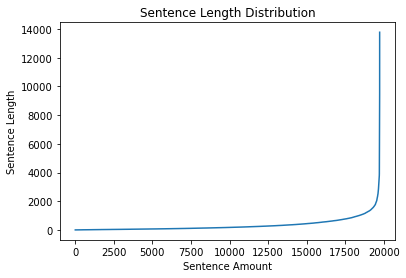

For MAX_SEQ_LEN, 1000 words in one sentce will reasonable to preseve 90% sentence and delete outlier value
************************************************** Start tokenize_data process **************************************************
**************************************** End tokenizer_data with 1.9259 seconds ****************************************

************************************************** Start glove_vect() process **************************************************



**************************************** End glove_vect() with 7.5219 seconds ****************************************

************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.0608 seconds ****************************************

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (InputLayer)   [(None, 500)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 500, 50)           1350750   
_________________________________________________________________
conv1D_layer_3 (Conv1D)      (None, 496, 32)           8032      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 32)            0         
______________________

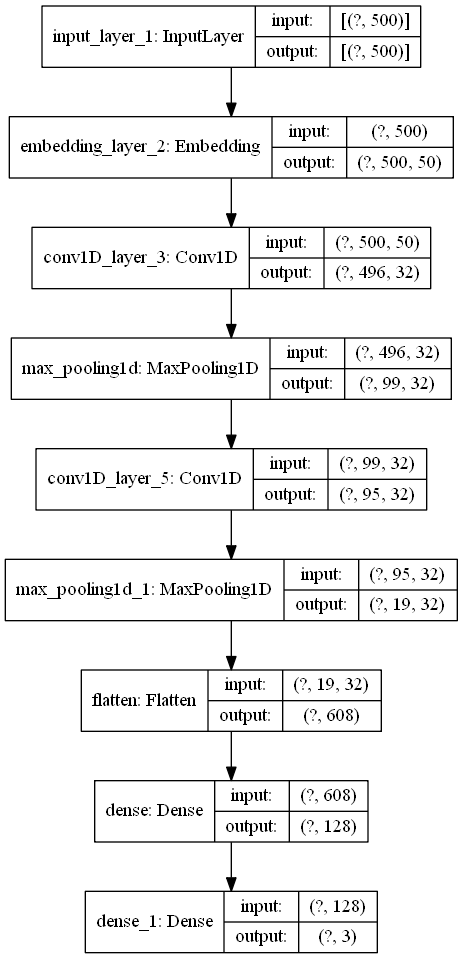

**************************************** Start CNN_Model Processing ****************************************
Train on 12629 samples, validate on 3947 samples
Epoch 1/3
12629/12629 [==============================] - 9s 726us/sample - loss: 0.8022 - tp: 6411.0000 - fp: 2364.0000 - tn: 22894.0000 - fn: 6218.0000 - accuracy: 0.6524 - precision: 0.7306 - recall: 0.5076 - auc: 0.8221 - F1: 0.4254 - val_loss: 0.5696 - val_tp: 2710.0000 - val_fp: 529.0000 - val_tn: 7365.0000 - val_fn: 1237.0000 - val_accuracy: 0.7646 - val_precision: 0.8367 - val_recall: 0.6866 - val_auc: 0.9135 - val_F1: 0.5360
Epoch 2/3
12629/12629 [==============================] - 4s 296us/sample - loss: 0.5295 - tp: 8949.0000 - fp: 1573.0000 - tn: 23685.0000 - fn: 3680.0000 - accuracy: 0.7793 - precision: 0.8505 - recall: 0.7086 - auc: 0.9255 - F1: 0.5893 - val_loss: 0.4987 - val_tp: 2846.0000 - val_fp: 487.0000 - val_tn: 7407.0000 - val_fn: 1101.0000 - val_accuracy: 0.7922 - val_precision: 0.8539 - val_recall: 0.7211 - v

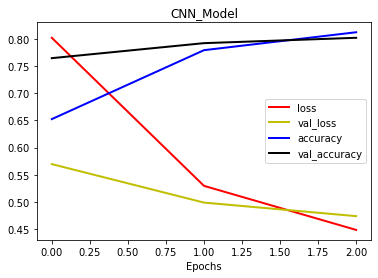

**************************************** End CNN_Model with 17.7496 seconds ****************************************

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (InputLayer)   [(None, 500)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 500, 50)           1350750   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 1,371,103
Trainable params: 20,353
Non-trainable params: 1,350,750
_________________________________________________________________


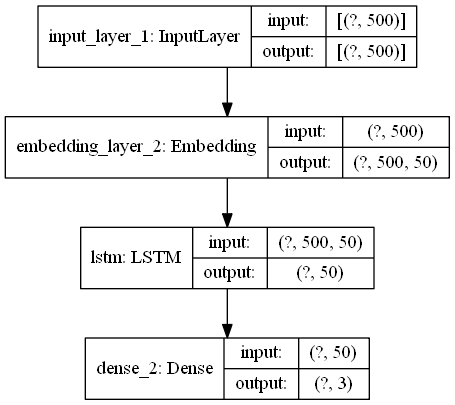

**************************************** Start LSTM_Model Processing ****************************************
Train on 12629 samples, validate on 3947 samples
Epoch 1/3
12629/12629 [==============================] - 103s 8ms/sample - loss: 0.9780 - tp: 5152.0000 - fp: 4065.0000 - tn: 21193.0000 - fn: 7477.0000 - accuracy: 0.5590 - precision: 0.5590 - recall: 0.4079 - auc: 0.7084 - F1: 0.2540 - val_loss: 0.9498 - val_tp: 2218.0000 - val_fp: 1729.0000 - val_tn: 6165.0000 - val_fn: 1729.0000 - val_accuracy: 0.5619 - val_precision: 0.5619 - val_recall: 0.5619 - val_auc: 0.7173 - val_F1: 0.2398
Epoch 2/3
12629/12629 [==============================] - 91s 7ms/sample - loss: 0.9531 - tp: 7011.0000 - fp: 5449.0000 - tn: 19809.0000 - fn: 5618.0000 - accuracy: 0.5628 - precision: 0.5627 - recall: 0.5552 - auc: 0.7162 - F1: 0.2401 - val_loss: 0.9492 - val_tp: 2218.0000 - val_fp: 1729.0000 - val_tn: 6165.0000 - val_fn: 1729.0000 - val_accuracy: 0.5619 - val_precision: 0.5619 - val_recall: 0.5619 -

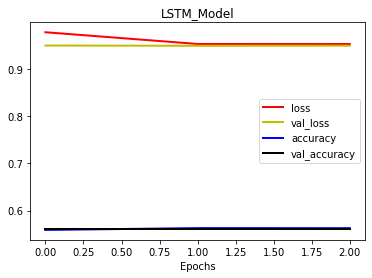

**************************************** End LSTM_Model with 297.4894 seconds ****************************************



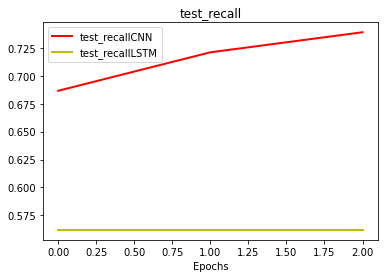

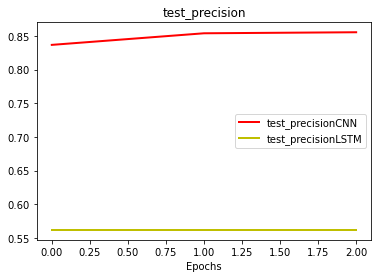

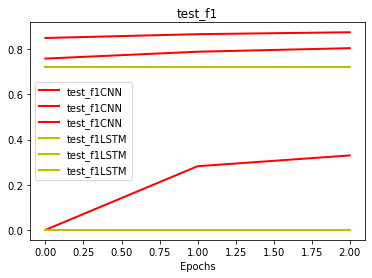

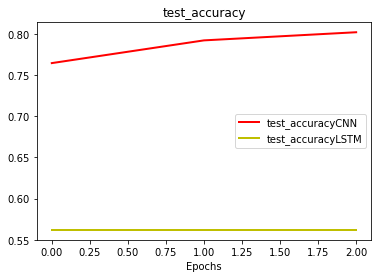

************************************************** Start TFIDF transfrom **************************************************
**************************************** End tfidf() with 3.3842 second ****************************************

************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.0618 seconds ****************************************



In [31]:
if __name__=="__main__":
    df_2, word_index, sequences, padded, embedding_matrix, history_cnn, history_lstm = main_1()

<br>

<br>

<br>

<br>

<a id="4.Sentiment Analysis"></a>
# 4.Sentiment Analysis
<a href="#1.Summary">Click this Link back to Top</a>

<a id="4.1 Read Data"></a>
## 4.1 Read Data
<a href="#1.Summary">Click this Link back to Top</a>

In [32]:
def read_data():
    """
    """
    with open("03_data/20_a4-data/q2/negative.review",'r', encoding='utf-8', errors='ignore') as f:
        # get all lines in this file
        lines_1 = f.read()
        # use bs4 to parse into bs4 format
        soup_1 = BeautifulSoup(lines_1, 'lxml')
        # according to requirements, we only need tag <review_text>. So, we extract 1000 records
        corpus_1 = soup_1.find_all('review_text')
        # using (.string) to get content between <review_text> and </review_text>
        list_1 = [x.string for x in corpus_1]
        
    with open("03_data/20_a4-data/q2/positive.review",'r', encoding='utf-8', errors='ignore') as f:
        # get all lines in this file
        lines_2 = f.read()
        # use bs4 to parse into bs4 format
        soup_2 = BeautifulSoup(lines_2, 'lxml')
        # according to requirements, we only need tag <review_text>. So, we extract 1000 records
        corpus_2 = soup_2.find_all('review_text')
        # using (.string) to get content between <review_text> and </review_text>
        list_2 = [x.string for x in corpus_2]
        
    data = {'REVIEW':list_1+list_2, 'SENTIMENT':[0]*len(list_1)+[1]*len(list_2)}
    df = pd.DataFrame(data)
    
    
    return df

<a id="4.3 Main Function"></a>
## 4.3 Main Function
<a href="#1.Summary">Click this Link back to Top</a>

In [33]:
def main_2():
    """
    1.readdata
    2.clean data
    3.tokenizer data
    4.load glove and using glove to build word vector sentence
    5.using glove to build word vector sentence
    6.split data
    7.Train CNN
    8.Train LSTM
    9.Train LR
    10.Train Normal NN
    """
    df_1 = read_data()
    df_2 = clean_data(df_1, column_1=df_1.columns[0], column_2=df_1.columns[1])
    tokenizer, word_index, sequences, padded = tokenize_data(df_2, column_1=df_2.columns[0])
    embedding_matrix, embedding_index = glove_vect(word_index, df_2)
    # actually, we don't directly this output
    output = embedding(word_index, padded, embedding_matrix)
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(padded, df_2, test_size=0.2)
    
    history_cnn = compile_fit(cnn_model(word_index, embedding_matrix, output_act='sigmoid', output_units=2), \
                          X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'binary_crossentropy', epoch_num=3)

    history_lstm = compile_fit(lstm_model(word_index, embedding_matrix, output_act='sigmoid', output_units=2), \
                          X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'binary_crossentropy', epoch_num=3)

    
    return df_2, tokenizer, word_index, sequences, padded, embedding_index, embedding_matrix, output

In [ ]:
# df_1 = read_data()
# df_2 = clean_data(df_1, column_1=df_1.columns[0], column_2=df_1.columns[1])
# tokenizer, word_index, sequences, padded = tokenize_data(df_2, column_1=df_2.columns[0])
# embedding_matrix, embedding_index = glove_vect(word_index, df_2)

# embedding_matrix.shape

# len(word_index)

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 1.219 second ****************************************

************************************************** Start tokenize_data process **************************************************
**************************************** End tokenizer_data with 0.4245 seconds ****************************************

************************************************** Start glove_vect() process **************************************************



**************************************** End glove_vect() with 8.6081 seconds ****************************************

************************************************** Start embedding process **************************************************
**************************************** End embedding() with 0.2219 seconds ****************************************

************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.009 seconds ****************************************

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (InputLayer)   [(None, 500)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 500, 50)           1191550   
__________________________________________

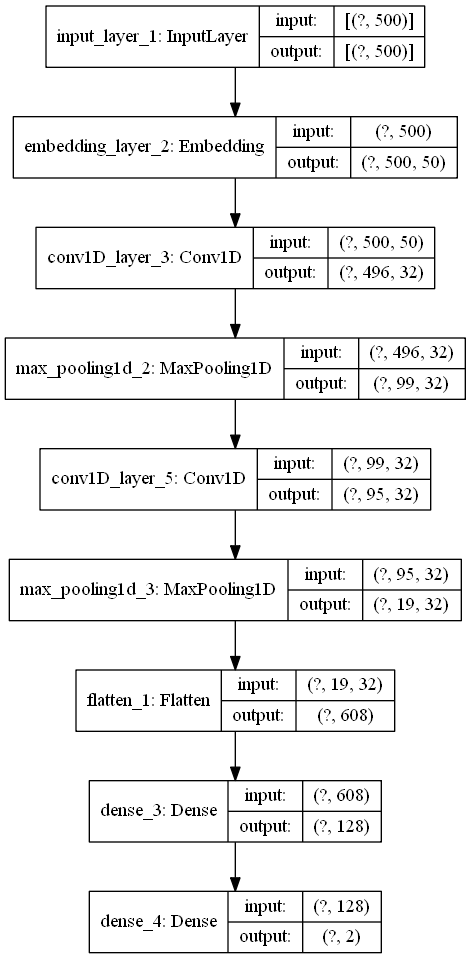

**************************************** Start CNN_Model Processing ****************************************
Train on 1280 samples, validate on 400 samples
Epoch 1/3
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.7019 - tp: 643.0000 - fp: 617.0000 - tn: 663.0000 - fn: 637.0000 - accuracy: 0.5109 - precision: 0.5103 - recall: 0.5023 - auc: 0.5100 - F1: 0.4906 - val_loss: 0.6927 - val_tp: 203.0000 - val_fp: 184.0000 - val_tn: 216.0000 - val_fn: 197.0000 - val_accuracy: 0.5250 - val_precision: 0.5245 - val_recall: 0.5075 - val_auc: 0.5311 - val_F1: 0.5008
Epoch 2/3
1280/1280 [==============================] - 0s 318us/sample - loss: 0.6706 - tp: 747.0000 - fp: 472.0000 - tn: 808.0000 - fn: 533.0000 - accuracy: 0.5992 - precision: 0.6128 - recall: 0.5836 - auc: 0.6411 - F1: 0.5991 - val_loss: 0.6717 - val_tp: 234.0000 - val_fp: 169.0000 - val_tn: 231.0000 - val_fn: 166.0000 - val_accuracy: 0.5850 - val_precision: 0.5806 - val_recall: 0.5850 - val_auc: 0.6308 - val_F1:

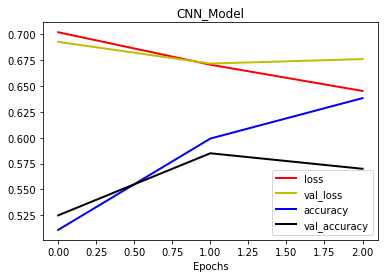

**************************************** End CNN_Model with 5.9968 seconds ****************************************

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (InputLayer)   [(None, 500)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 500, 50)           1191550   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 1,211,852
Trainable params: 20,302
Non-trainable params: 1,191,550
_________________________________________________________________


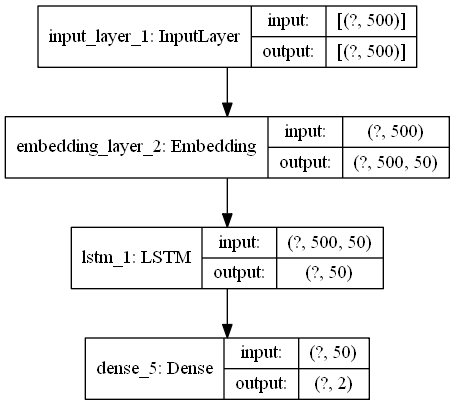

**************************************** Start LSTM_Model Processing ****************************************
Train on 1280 samples, validate on 400 samples
Epoch 1/3
1280/1280 [==============================] - 16s 13ms/sample - loss: 0.6936 - tp: 662.0000 - fp: 635.0000 - tn: 645.0000 - fn: 618.0000 - accuracy: 0.5133 - precision: 0.5104 - recall: 0.5172 - auc: 0.5036 - F1: 0.4637 - val_loss: 0.6933 - val_tp: 187.0000 - val_fp: 207.0000 - val_tn: 193.0000 - val_fn: 213.0000 - val_accuracy: 0.4725 - val_precision: 0.4746 - val_recall: 0.4675 - val_auc: 0.4773 - val_F1: 0.3209
Epoch 2/3
1280/1280 [==============================] - 11s 8ms/sample - loss: 0.6917 - tp: 655.0000 - fp: 613.0000 - tn: 667.0000 - fn: 625.0000 - accuracy: 0.5188 - precision: 0.5166 - recall: 0.5117 - auc: 0.5225 - F1: 0.3515 - val_loss: 0.6935 - val_tp: 187.0000 - val_fp: 209.0000 - val_tn: 191.0000 - val_fn: 213.0000 - val_accuracy: 0.4725 - val_precision: 0.4722 - val_recall: 0.4675 - val_auc: 0.4787 - val_F

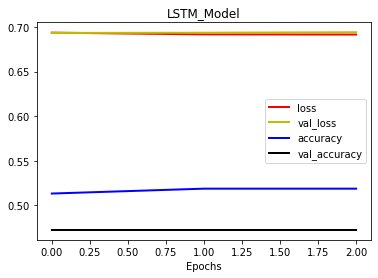

**************************************** End LSTM_Model with 35.9761 seconds ****************************************



In [34]:
if __name__=="__main__":
    df_2, tokenizer, word_index, sequences, padded, embedding_index, embedding_matrix, output = main_2()

<a id="5.Unused Code"></a>
# 5.Unused Code
<a href="#1.Summary">Click this Link back to Top</a>

In [ ]:
def load_glove(with_indexes=True):
    """
    I have 50dimension - 300 dimension, At puning stage i will use 50 dimension, but i will replace when i submit.
    This is one type of pretrained word vector. 
    https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer
    
    Argus:
    -----
    
    Return:
    ------
    word_to_index_dict:dictionary
        this contain {"word":index} and order by frequence {'the': 0,  ',': 1,'.': 2,'of': 3}
    index_to_embedding_array:np.array
        matrix with each word vecotr, for instance, 'the' vector will be a (50,) vector
    
    """
    # load the GloVe vectors in a dictionary:
#     embeddings_index = {}
#     # according to train speed, we can change 
#     f = open(r"D:\Downloads\glove.6B\glove.6B.50d.txt", 'r', encoding='utf-8')
#     for line in tqdm(f):
#         # 
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     f.close()
#     print('Found %s word vectors.' % len(embeddings_index))
#     return embeddings_index


    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    with open(r"D:\Downloads\glove.6B\glove.6B.50d.txt", 'r', encoding='utf-8') as glove_file:
        # i is idx, 
        for (i, line) in tqdm(enumerate(glove_file)):
            # vector is split by whitespace
            split = line.split(' ')
            # the first item is word
            word = split[0]
            # next [1:51] is dimension, because i read 50 dimension pretrain vector
            representation = split[1:]
            # transform to float type
            representation = np.array(
                [float(val) for val in representation]
            )
            # if we need index, add another seperate dictionary 
            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation
        _WORD_NOT_FOUND = [0.0]* len(representation)  # Empty representation for unknown words.
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(index_to_embedding_array + [_WORD_NOT_FOUND])
        #
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

In [ ]:
def glove_output(word_to_index_dict, index_to_embedding_array):
    """
    This part is only for validation and test
    """
    vocab_size, embedding_dim = index_to_embedding.shape
    print("Embedding is of shape: {}".format(index_to_embedding.shape))
    print("This means (number of words, number of dimensions per word)\n")
    print("The first words are words that tend occur more often.")

    print("Note: for unknown words, the representation is an empty vector,\n"
          "and the index is the last one. The dictionnary has a limit:")
    print("    {} --> {} --> {}".format("A word", "Index in embedding", "Representation"))
    
    word = "worsdfkljsdf"
    idx = word_to_index[word]
    embd = list(np.array(index_to_embedding[idx], dtype=int))  # "int" for compact print only.
    print("    {} --> {} --> {}".format(word, idx, embd))
    
    word = "the"
    idx = word_to_index[word]
    embd = list(index_to_embedding[idx])  # "int" for compact print only.
    print("    {} --> {} --> {}".format(word, idx, embd))

In [ ]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant


BASE_DIR = 'D:\\Downloads\\'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
# change encoding to utf-8 for glove.6B dataset
with open(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

In [ ]:
# type(labels)

# labels[1987]

# labels_2 = to_categorical(np.asarray(labels))

# labels_2.shape

In [ ]:
    # If i use 50d glove, this will be 50, max dimension is 300 dimendsion
#     EMBEDDING_DIM = 50
#     # create a empty matrix to filled in glove
#     embedding_matrix = np.zero((len(word_index) + 1, EMBEDDING_DIM))
#     for word, i in word_index.items():
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector
#     print(" Completed!")
#     df_1 = tf.nn.embedding_lookup(params = index_to_embedding_array, word_to_index[word], max_norm=None, name=None)
#     for idx, sentence in tqdm(enumerate(df['AUTHOR'][0:5])):
#         word_list = sentence.split(' ')
#         index_list = 
#         df_1 = tf.nn.embedding_lookup(index_to_embedding_array, [0,1])
#     return df_1
#     tensor_list=[]
#     for idx, sentence in tqdm(enumerate(df['AUTHOR'])):
#         word_list = sentence.split(' ')
#         index_list=[]
#         for word in word_list:
#             index_word = word_to_index_dict[word]
#             index_list.append(index_word)
#         tensor_col = tf.nn.embedding_lookup(index_to_embedding_array, index_list)
#         tensor_list.append(tensor_col)
#     df['tensor_col'] = tensor_list
#     return df